<a href="https://colab.research.google.com/github/biggymart/colab/blob/main/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Necessary Libraries

필요한 라이브러리를 임포트합니다.

In [ ]:
!pip install keras-ocr
import keras_ocr
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from pathlib import Path
from scipy import spatial
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# 2. Data, Data, Data

## 2-1. Data from ICDAR

최종적으로 우리가 원하는 Output의 모습:

    data_generator --> (image, lines)
    where, lines --> ((x1, y1), (x2, y2), (x3, y3), (x4, y4), c)

가장 먼저 할 일은 경로 접근하는 generator 만들기.

```
Folder Structure
.../ICDAR2019_Korean
|-- MLT
|    |-- korean_img (이미지 1,000장)
|    |-- korean_gt (레이블링)
|-- SynthText
     |-- korean_img (이미지 40,000장)
     |-- korean_gt (레이블링)
```


In [ ]:
# Bringing in the src data
BASE_DIR = '/content/drive/MyDrive/ICDAR2019_Korean/'

# 하위 경로 만들어주는 generator (리스트 버전)
def get_file_path(root_dir):
  file_path_list = []
  for root, _, files in os.walk(root_dir, topdown=True):
    for name in files:
      file_path_list.append(os.path.join(root, name))
  return file_path_list

# 경로를 통해 파일에 접근해서 내용을 퍼오면 되겠다
def data_iterator(gt_path):
  for path in gt_path:
    with open(path, 'r') as gt_file:
      annotations = []
      lines = [line.strip() for line in gt_file]
      # print("lines 타입 및 길이")
      # print(type(lines), len(lines))

      for one_line in lines:
        try:
          # print("one_line", one_line)
          x1, y1, x2, y2, x3, y3, x4, y4, lang, c = one_line.split(',')
          if lang not in ['Korean', 'Latin', 'Symbols']:
            # print("한국어,영어,기호가 아닙니다")
            # print(lang)
            continue

          # '###' 부분은 애초에 annotations에 넣어주지 않도록 처리하는 부분
          if c == '###':
            # print("c가 ###입니다 패스")
            continue

        except ValueError:
          # print("아마도 ,(콤마)이 레이블링에 있나보다 패스")
          continue
        
        formatted_line = ((x1, y1), (x2, y2), (x3, y3), (x4, y4), c)
        # print("formatted_line", formatted_line)
        annotations.append(formatted_line)
        # print("annotations 길이가 이제 이 정도:", len(annotations))

      img_path = os.path.join(
            path[:path.index("korean_gt")], # /content/drive/MyDrive/ICDAR2019_Korean/MLT 혹은 SynthText/
            "korean_img/",
            path.split('/')[-1].replace('.txt', '.jpg')
          )
      image = cv2.imread(img_path)
      yield image, np.array(annotations, dtype='object')


if __name__ == "__main__":
  mlt_gt_path = get_file_path(BASE_DIR + "MLT/korean_gt/")
  mlt_data_generator = data_iterator(mlt_gt_path)

In [ ]:
# # 이미지와 거기에 태깅된 레이블 한 개 보여주기
# image, lines = mlt_data_generator.__next__()
# print(pd.DataFrame(lines))
# print("type(lines):", type(lines), "len(lines)", len(lines))
# print("annotation shape is: ", lines.shape)
# print("Image shape is: ", image.shape)
# plt.imshow(image,vmax=640)

# # 전체 running 해보기
# for count, _ in tqdm(mlt_data_generator):
#   try:
#     next(mlt_data_generator)
#   except StopIteration:
#     print("iteration over")
#     break

In [ ]:
# # create a batch generator
# def batch_generator(data_generator, batch_size=1):
#   while True:
#     batch = [next(data_generator) for n in range(batch_size)]
#     X = np.array([entry[0] for entry in batch])
#     y = [entry[1] for entry in batch]
#     yield X, y

# # batch generator example
# mlt_batch_generator = batch_generator(mlt_data_generator, batch_size=5)
# X, y = mlt_batch_generator.__next__()
# print(len(X))
# print(len(y))

Recognizer input으로 converting 하는 코드 블럭

Here, we have two main functions. For one main function, it has two dependent functions.

```
|-- save_cropped_img()
|-- convert_image_generator_to_recognizer_input()
    |-- warpBox()
        |-- get_rotated_width_height()
```



In [ ]:
# dependency code 1
def warpBox(
    image,
    box, 
    target_height=None,
    target_width=None, 
    margin=0
    ):
  w, h = get_rotated_width_height(box) # dependency code 2
  assert (target_width is None and target_height is None) or (
        target_width is not None and target_height is not None
    ), "Either both or neither of target width and height must be provided."
  if target_width is None and target_height is None:
    target_width = w
    target_height = h
  scale = min(target_width / w, target_height / h)
  dst_box = np.array([(margin, margin),
                      (scale * w - margin, margin),
                      (scale * w - margin, scale * h - margin), 
                      (margin, scale * h - margin)], dtype="float32")
  M = cv2.getPerspectiveTransform(box, dst_box)
  crop = cv2.warpPerspective(image, M, dsize=(int(scale * w), int(scale * h)))
  return crop


# dependency code 2
def get_rotated_width_height(box):
    """
    새로운 이미지의 너비 및 높이
    box = ((x1, y1), (x2, y2), (x3, y3), (x4, y4))
    """
    w = (
        spatial.distance.cdist([box[0]], [box[1]], "euclidean")
        + spatial.distance.cdist([box[2]], [box[3]], "euclidean")
        ) / 2
    h = (
        spatial.distance.cdist([box[0]], [box[3]], "euclidean")
        + spatial.distance.cdist([box[1]], [box[2]], "euclidean")
        ) / 2
    return int(w[0][0]), int(h[0][0])


# main code number 1
def convert_image_generator_to_recognizer_input(
    image_generator, 
    target_width, 
    target_height, 
    margin=0
    ):
  while True:
    # image는 이미지, lines 는 <class 'numpy.ndarray'>
    image, lines = next(image_generator)
    # print("type(lines)", type(lines))
    # print("lines.shape", lines.shape)

    for i in range(lines.shape[0]):
      # print(i, "번째 crop 하는 중")
      try:
        box = lines[i][:-1]
        word = lines[i][-1]

        ### 잘린 이미지 돌려주는 부분 ###
        box_np = np.array([(box[0][0], box[0][1]),
                        (box[1][0], box[1][1]),
                        (box[2][0], box[2][1]),
                        (box[3][0], box[3][1])], dtype="float32")

        crop = warpBox( # dependency code 1
            image=image,
            box=box_np,
            target_width=target_width,
            target_height=target_height,
            margin=margin,
            )
        # print(word)
        yield crop, word
      except Exception as e:
        print("에러명: ", e, "at", i)
        break


# main code number 2
def save_cropped_img(recognizer_generator, save_path):
  saved_img_count = 0
  for count, _ in tqdm(recognizer_generator):
    try:
      cropped_img, word = next(recognizer_generator)
      w = cropped_img.shape[0]
      h = cropped_img.shape[1]

      # 세로로 써져있는 글은 무시
      if w > h:
        continue
      else:
        cv2.imwrite(save_path + word +".png", cropped_img)
        saved_img_count += 1
    except Exception as e:
      print("[INFO] saved", saved_img_count, "images")
      print(e)
      break


if __name__ == "__main__":
  mlt_recognizer_generator = convert_image_generator_to_recognizer_input(
      mlt_data_generator, 
      target_width=300, 
      target_height=75,
      margin=2
  )

  # # 예시 하나만 보기
  # cropped_img, word = mlt_recognizer_generator.__next__()
  # print("word:", word)
  # print("cropped_img.shape:", cropped_img.shape)
  # plt.imshow(cropped_img, vmax=640)

  OUTPUT_PATH = '/content/drive/MyDrive/ICDAR2019_Korean/input/'

  if not os.path.isdir(OUTPUT_PATH):
    os.mkdir("/content/drive/MyDrive/ICDAR2019_Korean/input/")
    os.mkdir("/content/drive/MyDrive/ICDAR2019_Korean/input/synth/")
    os.mkdir("/content/drive/MyDrive/ICDAR2019_Korean/input/mlt/")

  save_cropped_img(mlt_recognizer_generator, OUTPUT_PATH + "mlt/")

In [ ]:
# # Destroy everything in output folder if you don't like it or want to start over.
# !rm -rf /content/drive/MyDrive/ICDAR2019_Korean/input/

## 2-2. Creating our own synthetic data

랜덤 str 5글자 이미지 생성기

In [ ]:
import os
import io
import glob
import random
import pandas as pd
from PIL import Image, ImageFont, ImageDraw

IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75

fonts_dir = "/content/drive/MyDrive/ICDAR2019_Korean/fonts"
output_dir = "/content/drive/MyDrive/ICDAR2019_Korean/input"


def generate_hangul_images(label_file, fonts_dir, output_dir):
    image_base_dir = os.path.join(output_dir, 'hangul-images')
    if not os.path.exists(image_base_dir):
        os.makedirs(os.path.join(image_base_dir))

    # Get a list of the fonts.
    fonts = glob.glob(os.path.join(fonts_dir, '*.ttf'))

    labels_csv = io.open(os.path.join(output_dir, 'labels-map.csv'), 'w',
                         encoding='utf-8')

    total_count = 0
    prev_count = 0
    for word in words_lst:
      try:
        # Print image count roughly every 5000 images.
        if total_count - prev_count > 5000:
            prev_count = total_count
            print('{} images generated...'.format(total_count))

        for font_dir in fonts:
            total_count += 1
            image = Image.new('L', (IMAGE_WIDTH, IMAGE_HEIGHT), color=(255))
            font = ImageFont.truetype(font_dir, 48)
            drawing = ImageDraw.Draw(image)
            w, h = drawing.textsize(word, font=font)
            drawing.text(
                ((IMAGE_WIDTH-w)/2, (IMAGE_HEIGHT-h)/2),
                word,
                fill=(0),
                font=font
            )
            image_dir = os.path.join(image_base_dir, (font_dir.split('/')[-1]).split('.')[-2])
            if not os.path.exists(image_dir):
                os.makedirs(os.path.join(image_dir))

            file_string = '{}.png'.format(word)
            file_path = os.path.join(image_dir, file_string)
            image.save(file_path, 'PNG')
            labels_csv.write(u'{},{}\n'.format(file_path, word))
      
      except Exception as e:
        print(e)
        continue

    print('Finished generating {} images.'.format(total_count))
    labels_csv.close()


if __name__ == "__main__":
  with open("/content/drive/MyDrive/ICDAR2019_Korean/2350_hangul.txt") as f:
    whole_txt = f.read()
  recognizer_hangul = whole_txt.replace('\n', '')

  words_lst = []
  for i in range(2350):
    rand_word = []
    for i in range(5):
      rand_char = random.choice(recognizer_hangul)
      rand_word.append(rand_char)
    rand_word_out = "".join(rand_word)
    words_lst.append(rand_word_out)
  
  generate_hangul_images(words_lst, fonts_dir, output_dir)

5010 images generated...
10020 images generated...
15030 images generated...
20040 images generated...
Finished generating 23500 images.


In [ ]:
# !rm -rf /content/drive/MyDrive/ICDAR2019_Korean/input/hangul-images

## 2-3. Drawing images with texts

content = random_ko_x.txt

이렇게 합성된 이미지를 만들고 난 다음에 2-1 에서 사용된 crop 함수로 짤라낼 수도 있음.

In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageOps
from matplotlib.pyplot import imshow


with Image.open("base_img.jpg") as base:

  txt = Image.new("L", (500, 50)) # 텍스트 이미지 도화지
  fnt = ImageFont.truetype('malgun.ttf', 30)
  dctx = ImageDraw.Draw(txt)
  theta = 10

  content = u"한국어 짱짱짱"
  dctx.text((0,0), text=content, fill="#eeeeff", font=fnt)
  rotated = txt.rotate(theta, expand=1)
  txtsz = dctx.textsize(content, fnt)
  print(base.width) # 474
  print(txtsz) # 161, 33

  base.paste(ImageOps.colorize(rotated, (0,0,0), (255,255,84)),
             box=(base.width - txtsz[0] - 20, 20),
             mask=rotated)

imshow(base)
base.save("processed_img.jpg")

# 3. Modeling

## 3-1. Detector (CRAFT)

detector는 그냥 그대로 쓰자

대신 pipeline에서 어떻게 연결되는지 제대로 파악해야 함

keras_ocr에서 recognizer 가져와야 함...? 그냥 위에 있는 파이토치 쓰는 게 어때 (된다고 하면...)

In [ ]:
BASE_DIR = '/content/drive/MyDrive/ICDAR2019_Korean/'

detector = keras_ocr.detection.Detector(weights='clovaai_general')

# 이미지 한 장으로 성능 확인하기
image1 = cv2.imread(BASE_DIR + "novel_eg2.jpg")
image1 = np.expand_dims(image1, axis=0)
boxes = detector.detect(images=image1)

# print(boxes[0])
# boxes[0].shape (135, 4, 2)


# recognizer = keras_ocr.recognition.Recognizer(
#     alphabet=hangul_alphabet,
#     weights='kurapan'
# )

# recognizer.compile()
# for layer in recognizer.backbone.layers:
#   layer.trainable = False

##################################################

image1 = cv2.imread(BASE_DIR + "novel_eg2.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

f, ax = plt.subplots(1, 1, figsize=(16,16))
# ax = ax.flatten()

# 지금은 이미지 한장으로만 하는 거라서 loop 불필요
# boxes의 첫번째 인덱스에 해당함
# 즉, 
# for img_idx in range(images):
# for box_idx in range(boxes[0].shape[0]):
#  vertices = [
#                (boxes[img_idx][box_idx][0][0], boxes[img_idx][box_idx][0][1]),
#                (boxes[img_idx][box_idx][1][0], boxes[img_idx][box_idx][1][1]),
#                (boxes[img_idx][box_idx][2][0], boxes[img_idx][box_idx][2][1]),
#                (boxes[img_idx][box_idx][3][0], boxes[img_idx][box_idx][3][1])
#            ]

# boxes.[0].shape == (135, 4, 2) --> boxes.[0].shape[0] == 135
for box_idx in range(boxes[0].shape[0]):
  vertices = [
                (boxes[0][box_idx][0][0], boxes[0][box_idx][0][1]),
                (boxes[0][box_idx][1][0], boxes[0][box_idx][1][1]),
                (boxes[0][box_idx][2][0], boxes[0][box_idx][2][1]),
                (boxes[0][box_idx][3][0], boxes[0][box_idx][3][1])
            ]
  bbox = patches.Polygon(
                    vertices,
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none',
                )
  ax.add_patch(bbox)

ax.imshow(image1)

## 3-2. Recognizer (CRNN PyTorch)

url: https://www.youtube.com/watch?v=IcLEJB2pY2Y&t=28s

Convolutional-RNN + CTC Loss

In essence, it is a classification problem (classifying characters)

The file name is the label.

Directory structure:

```
Captcha
|-- input
|-- src
     |-- config.py
     |-- dataset.py
     |-- viewdata.ipynb
     |-- train.py
     |-- engine.py
     |-- model.py
```



In [ ]:
# config.py
DATA_DIR = "/content/drive/MyDrive/ICDAR2019_Korean/input/mlt/"
BATCH_SIZE = 5
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75 
NUM_WORKERS = 2
EPOCHS = 200
DEVICE = "cuda"

In [ ]:
# dataset.py
import albumentations # used for augmentation
import torch
import numpy as np
from PIL import Image
from PIL import ImageFile


# set a config for ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# In case you have truncated images, you also loade those

class ClassificationDataset:

  def __init__(self, image_paths, targets, resize=None):
    self.image_paths = image_paths # list; path to different images
    self.targets = targets
    self.resize = resize # (h, w)
    # very simple augmentation
    # you can do more if you want
    self.aug = albumentations.Compose([albumentations.Normalize(always_apply=True)])

  def __len__(self):
    # The length that you will return when len() is used
    return len(self.image_paths)

  def __getitem__(self, item):
    # This is a bit different from how it's done in the keras tutorial
    # Arguments
      # item: the item that you want
    image = Image.open(self.image_paths[item]).convert("RGB")
    targets = self.targets[item]

    if self.resize is not None:
      # PIL is width-first
      # PIL로 읽어오면 (w, h) 순인데 --> (h, w)로 바꿔줌
      image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

    image = np.array(image)
    augmented = self.aug(image=image)
    image = augmented["image"]
    # convert to channel first format (C, H, W)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    return {
        "images": torch.tensor(image, dtype=torch.float),
        "targets": torch.tensor(targets, dtype=torch.long)
        }

In [ ]:
# view_data.ipynb
import matplotlib.pyplot as plt
%matplotlib inline

# tensor -> numpy
npimg = train_dataset[0]["images"].numpy() # you can also see different images, e.g> 0 --> 199
npimg.shape # (3, 75, 300)

# Make channel last
# This would allow you to take a look at what you did
# in dataloader, and then you can do the inverse of it
np.transpose(npimg, (1, 2, 0)).shape # (75, 300, 3)

plt.imshow(np.transpose(npimg, (1, 2, 0)))
# you can see the image

NameError: ignored

In [ ]:
# engine.py
# training and evaluation function
from tqdm import tqdm
import torch
# import config


def train_fn(model, data_loader, optimizer):
  model.train()
  fin_loss = 0
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    # For every batch, put it in the device in use
    for k, v in data.items():
      data[k] = v.to(DEVICE) # config.DEVICE
      optimizer.zero_grad()

      # Your model should return 2 things
      # (1) predictions (2) loss
      _, loss = model(**data) # All the variable names should be the same
      loss.backward()
      optimizer.step() # Notice that we are not using scheduler here.
      fin_loss += loss.item()
    return fin_loss / len(data_loader)

def eval_fn(model, data_loader):
  model.eval()
  # torch.no_grad()

  fin_loss = 0
  fin_preds = []
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    for k, v in data.items():
      data[k] = v.to(DEVICE) # config.DEVICE
      optimizer.zero_grad()

      # In eval mode, you need predictions.
      batch_pred, loss = model(**data)
      # No backpropagation, nor optimizer needed.
      fin_loss += loss.item()
      fin_preds.append(batch_preds)
    return fin_preds, fin_loss / len(data_loader)

In [ ]:
# model.py
import torch
from torch import nn
from torch.nn import functional as F

class CaptchaModel(nn.Module):
  def __init__(self, num_chars):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
    self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 2))

    self.linear_1 = nn.Linear(1152, 64)
    # 64 is just arbitrary choice, you can make changes
    # Effect: reduces the output filters from 1152 to 64
    self.drop_1 = nn.Dropout(0.2)

    self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25)
    self.output = nn.Linear(64, num_chars + 1) # Plus one for unknown
  
  # targets can be None in case of inference, not training
  def forward(self, images, targets=None):
    bs, c, h, w = images.size()
    print(bs, c, h, w)
    x = F.relu(self.conv_1(images))
    print("1", x.size())
    x = self.max_pool_1(x)
    print("2", x.size())
    x = F.relu(self.conv_2(x))
    print("3", x.size())
    x = self.max_pool_2(x) # torch.Size([1, 64, 18, 75]) # bs, filters, h, w
    print("4", x.size())
    x = x.permute(0, 3, 1, 2) # (bs, w, filters, h) # we do this to see the width of the image
    print("5", x.size())
    x = x.view(bs, x.size(1), -1) # x.size(1) == 75; which is width
    x = self.linear_1(x)
    x = self.drop_1(x) # Dropout will not change the size
    print("6", x.size()) # torch.Size([1, 75, 64]) # 75 timesteps and for each timestep there are 64 different values
    x, _ = self.gru(x) # second one is a tuple; refer to other documentation
    print("7", x.size())
    x = self.output(x) # torch.Size([1, 75, 20]); 20 outputs for each timestep
    print("8", x.size())
    x = x.permute(1, 0, 2)
    print("9", x.size())
    if targets is not None:
      # Use loss function that makes sense with sequence
      log_softmax_values = F.log_softmax(x, 2)
      print("10", log_softmax_values.size())
      input_lengths = torch.full(
          size=(bs, ), 
          fill_value=log_softmax_values.size(0),
          dtype=torch.int32
      )
      print("11", input_lengths)
      target_lengths = torch.full(
          size=(bs, ), 
          fill_value=log_softmax_values.size(1),
          dtype=torch.int32
      )
      print("12", target_lengths)
      loss = nn.CTCLoss(blank=0)(
          log_softmax_values, targets, input_lengths, target_lengths
      )
      return x, loss
    return x, None


# if __name__ == "__main__":
#   cm = CaptchaModel(19)
#   img = torch.rand(1, 3, 75, 300) # This is the size that we chose in config
#   target = torch.randint(1, 20, (1, 5)) # Similar to five characters captcha
#   x, loss = cm(img, target)

In [ ]:
# train.py
import os
import glob
import torch
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from pprint import pprint

# import config
# import dataset
# from model import CaptchaModel
# import engine


def decode_predictions(preds, encoder):
  preds = preds.permute(1, 0, 2) # bs, timesteps, predictions
  preds = torch.softmax(preds, 2)
  preds = torch.argmax(preds, 2)
  preds = preds.detach().cpu().numpy()
  cap_preds = []
  # a very crude way to decode
  for j in range(preds.shape[0]):
    temp = []
    for k in preds[j, :]:
      k = k - 1
      if k == -1:
        temp.append("°")
      else:
        temp.append(encoder.inverse_transform([k])[0])
    tp = "".join(temp)
    cap_preds.append(tp)
  return cap_preds

# It is possible to grab all the image files
# and create csv file if you want
def run_training():
  # image_files = glob.glob(os.path.join(DATA_DIR, "*.png")) #config.DATA_DIR
  words_csv = pd.read_csv("/content/drive/MyDrive/ICDAR2019_Korean/input/labels-map.csv")
  image_files = words_csv.iloc[:, 0]

  # ".../../abcde.png" --> list of strings
  targets_orig = [x.split("/")[-1][:-4] for x in image_files]
  print("targets_orig", targets_orig)
  # "abcde" --> [['a'], ['b'], ['c'], ['d'], ['e']], list of lists
  targets =[[c for c in x] for x in targets_orig]
  print("targets", targets)
  targets_flat = [c for clist in targets for c in clist]
  print("targets_flat", targets_flat)

  lbl_enc = preprocessing.LabelEncoder()
  lbl_enc.fit(targets_flat)
  # print(targets)
  print(np.unique(targets_flat).shape)
  # Now we want to make encoded targets
  # and convert these to numpy array.
  targets_enc = [lbl_enc.transform(x) for x in targets]
  # Add 1 because we want 0 for UNKNOWN
  targets_enc = np.array(targets_enc) + 1
  # print(targets_enc) # would print a numpy array, shape of (N, 5)
  # print(len(lbl_enc.classes_)) # 19 for captchas

  (train_imgs, test_imgs, 
   train_targets, test_targets, 
   train_orig_targets, test_orig_targets) = model_selection.train_test_split(
       image_files, 
       targets_enc, 
       targets_orig, test_size=0.1, random_state=42
       )
  
  train_dataset = ClassificationDataset( # dataset.ClassificationDataset
      image_paths=train_imgs, 
      targets=train_targets, 
      resize=(IMAGE_HEIGHT, IMAGE_WIDTH) # config.IMAGE_HEIGHT, config.IMAGE_WIDTH
      )
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE, # config.BATCH_SIZE
      num_workers=NUM_WORKERS, # config.NUM_WORKERS
      shuffle=True
  )

  test_dataset = ClassificationDataset( # dataset.ClassificationDataset
      image_paths=test_imgs, 
      targets=train_targets, 
      resize=(IMAGE_HEIGHT, IMAGE_WIDTH) # config.IMAGE_HEIGHT, config.IMAGE_WIDTH
      )
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=BATCH_SIZE, # config.BATCH_SIZE
      num_workers=NUM_WORKERS, # config.NUM_WORKERS
    shuffle=False
  )

  # Now we can create our model
  # but we don't have one
  # so we have to make one.
  model = CaptchaModel(num_chars=len(lbl_enc.classes_))
  model.to(DEVICE) #config.DEVICE

  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, factor=0.8, patience=5, verbose=True
  )
  for epoch in range(EPOCHS): #config.EPOCHS
    train_loss = train_fn(model, train_loader, optimizer) # engine.train_fn(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_fn(model, test_loader) # engine.eval_fn(model, test_loader)
    valid_cap_preds = []
    for vp in valid_preds:
      current_preds = decode_predictions(valid_preds, lbl_enc)
      valid_cap_preds.extend(current_preds)
    # You can check other examples by changing indexes
    pprint(list(zip(test_orig_targets, valid_cap_preds))[6:11])
    print(f"Epoch: {epoch}, train_loss={train_loss}, valid_loss={valid_loss}")

if __name__ == "__main__":
  run_training()
  # 75 values: "°6666°°°°°ddddddd°°°°77°°8°°h°°°°°"

targets_orig ['부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '부뺘쵸낙첩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '춧뺍벌곶딩', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '걍렀벳현모', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '뱄삶디뱐젖', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '닙듕곈덟걷', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '뮨챕꿋낌러', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '큠뛸섧뇻라', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '괠꽹본붚롬', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '왑읏뇩믐취', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '돔헒엉써수', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '늄갼쵠지돋', '앤츌룬것

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


NameError: ignored

## 3-3. Recognizer (CRNN Keras)

In [ ]:
# !rm -rf /content/captcha_images_v2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    633      0 --:--:-- --:--:-- --:--:--   630
100 8863k  100 8863k    0     0  28.5M      0 --:--:-- --:--:-- --:--:-- 28.5M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace captcha_images_v2/36nx4.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace captcha_images_v2/36nx4.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'p', 'n', 'b', 'y', 'x', '8', 'e', 'g', 'd', '7', '4', '6', '5', 'f', 'w', '2', 'm', '3', 'c'}


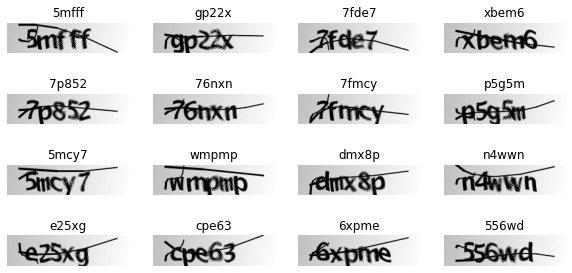

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

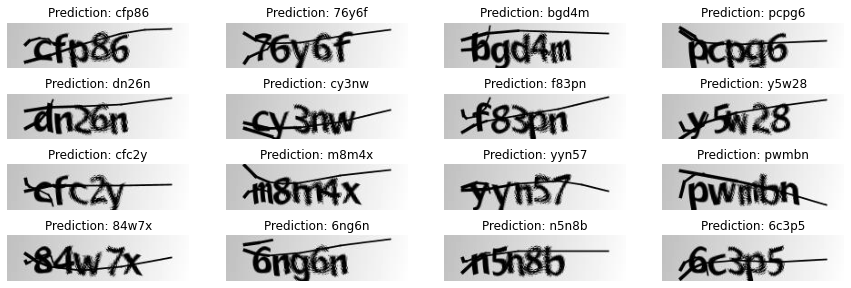

In [10]:
### 1. Setup
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 2. Load the data
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

### 3. Preprocessing
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


### 4. Create Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

### 5. Visualize the data
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### 6. Model

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

### 7. Training
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


### 8. Infernece

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# STN and Pipeline

In [ ]:
 # https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/recognition.py
 if stn:
        # pylint: disable=pointless-string-statement
        """Spatial Transformer Layer
        Implements a spatial transformer layer as described in [1]_.
        Borrowed from [2]_:
        downsample_fator : float
            A value of 1 will keep the orignal size of the image.
            Values larger than 1 will down sample the image. Values below 1 will
            upsample the image.
            example image: height= 100, width = 200
            downsample_factor = 2
            output image will then be 50, 100
        References
        ----------
        .. [1]  Spatial Transformer Networks
                Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
                Submitted on 5 Jun 2015
        .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
        .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
        """
        stn_input_output_shape = (
            width // pool_size ** 2,
            height // pool_size ** 2,
            filters[6],
        )
        stn_input_layer = keras.layers.Input(shape=stn_input_output_shape)
        locnet_y = keras.layers.Conv2D(16, (5, 5), padding="same", activation="relu")(
            stn_input_layer
        )
        locnet_y = keras.layers.Conv2D(32, (5, 5), padding="same", activation="relu")(
            locnet_y
        )
        locnet_y = keras.layers.Flatten()(locnet_y)
        locnet_y = keras.layers.Dense(64, activation="relu")(locnet_y)
        locnet_y = keras.layers.Dense(
            6,
            weights=[
                np.zeros((64, 6), dtype="float32"),
                np.float32([[1, 0, 0], [0, 1, 0]]).flatten(),
            ],
        )(locnet_y)
        localization_net = keras.models.Model(inputs=stn_input_layer, outputs=locnet_y)
        x = keras.layers.Lambda(_transform, output_shape=stn_input_output_shape)(
            [x, localization_net(x)]
        )
    x = keras.layers.Reshape(
        target_shape=(
            width // pool_size ** 2,
            (height // pool_size ** 2) * filters[-1],
        ),
        name="reshape",
    )(x)

In [ ]:
# https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py
import numpy as np

from . import detection, recognition, tools


class Pipeline:
    """A wrapper for a combination of detector and recognizer.
    Args:
        detector: The detector to use
        recognizer: The recognizer to use
        scale: The scale factor to apply to input images
        max_size: The maximum single-side dimension of images for
            inference.
    """

    def __init__(self, detector=None, recognizer=None, scale=2, max_size=2048):
        if detector is None:
            detector = detection.Detector()
        if recognizer is None:
            recognizer = recognition.Recognizer()
        self.scale = scale
        self.detector = detector
        self.recognizer = recognizer
        self.max_size = max_size

    def recognize(self, images, detection_kwargs=None, recognition_kwargs=None):
        """Run the pipeline on one or multiples images.
        Args:
            images: The images to parse (can be a list of actual images or a list of filepaths)
            detection_kwargs: Arguments to pass to the detector call
            recognition_kwargs: Arguments to pass to the recognizer call
        Returns:
            A list of lists of (text, box) tuples.
        """

        # Make sure we have an image array to start with.
        if not isinstance(images, np.ndarray):
            images = [tools.read(image) for image in images]
        # This turns images into (image, scale) tuples temporarily
        images = [
            tools.resize_image(image, max_scale=self.scale, max_size=self.max_size)
            for image in images
        ]
        max_height, max_width = np.array(
            [image.shape[:2] for image, scale in images]
        ).max(axis=0)
        scales = [scale for _, scale in images]
        images = np.array(
            [
                tools.pad(image, width=max_width, height=max_height)
                for image, _ in images
            ]
        )
        if detection_kwargs is None:
            detection_kwargs = {}
        if recognition_kwargs is None:
            recognition_kwargs = {}
        box_groups = self.detector.detect(images=images, **detection_kwargs)
        prediction_groups = self.recognizer.recognize_from_boxes(
            images=images, box_groups=box_groups, **recognition_kwargs
        )
        box_groups = [
            tools.adjust_boxes(boxes=boxes, boxes_format="boxes", scale=1 / scale)
            if scale != 1
            else boxes
            for boxes, scale in zip(box_groups, scales)
        ]
        return [
            list(zip(predictions, boxes))
            for predictions, boxes in zip(prediction_groups, box_groups)
        ]